## 实战案例：Elo商户类别推荐

## 一、EDA (数据探索性分析：new_merchant_transactions、historical_transactions)

### 1. 导入数据集

In [3]:
# 导入库
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# 查看竞赛提供的所有文件
os.listdir('../data/')

['Data Dictionary.xlsx',
 'Data_Dictionary.xlsx',
 'historical_transactions.csv',
 'merchants.csv',
 'merchants_new.csv',
 'new_merchant_transactions.csv',
 'sample_submission.csv',
 'test.csv',
 'train.csv']

In [5]:
# 导入数据集
df = pd.read_excel('../data/Data_Dictionary.xlsx', sheet_name='history', skiprows=2)
new_transaction = pd.read_csv('../data/new_merchant_transactions.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
history_transaction = pd.read_csv('../data/historical_transactions.csv',nrows=10000)
merchant = pd.read_csv('../data/merchants_new.csv')

In [6]:
# 查看商家历史交易字段
print(df.shape)
for va in df.values:
    print('Column:', va[0], ' Description:', va[1])
    
df = pd.read_excel('../data/Data_Dictionary.xlsx', sheet_name='new_merchant_period', skiprows=2)
print(df.shape)
for va in df.values:
    print('Column:', va[0], ' Description:', va[1])
# 结论：可以看出两张交易记录信息表字段一致，且除了数量与金额之外均为类别字段
# 可按照与商家信息表类似的方式对交易记录表进行简单分析，但由于交易记录表的id索引并不唯一
# 所有的类别字段都值得进行探索分析，当然也可以顺带进行数据的处理
# 特别注意：有时离散字段与连续字段之间的分界并不明显，有的字段既可以作为离散字段处理，又可以
# 作为连续字段进行处理，此外，这里出现了很特别的一个字段就是时间，这里我们会专门讲解时间字段的处理

(14, 2)
Column: card_id  Description: Card identifier
Column: month_lag  Description: month lag to reference date
Column: purchase_date  Description: Purchase date
Column: authorized_flag  Description: Y' if approved, 'N' if denied
Column: category_3  Description: anonymized category
Column: installments  Description: number of installments of purchase
Column: category_1  Description: anonymized category
Column: merchant_category_id  Description: Merchant category identifier (anonymized )
Column: subsector_id  Description: Merchant category group identifier (anonymized )
Column: merchant_id  Description: Merchant identifier (anonymized)
Column: purchase_amount  Description: Normalized purchase amount
Column: city_id  Description: City identifier (anonymized )
Column: state_id  Description: State identifier (anonymized )
Column: category_2  Description: anonymized category
(14, 2)
Column: card_id  Description: Card identifier
Column: month_lag  Description: month lag to reference date
C

### 2. 离散、连续数据处理

In [7]:
# 校验columns
numeric_cols = [ 'installments', 'month_lag', 'purchase_amount']
category_cols = ['authorized_flag', 'card_id', 'city_id', 'category_1',
       'category_3', 'merchant_category_id', 'merchant_id', 'category_2', 'state_id',
       'subsector_id']
time_cols = ['purchase_date']
assert len(numeric_cols) + len(category_cols) + len(time_cols) == new_transaction.shape[1]

In [8]:
# 对比商家信息表和交易表，找出共有的字段，说不定可供表联合，可以发现与商家信息id有重复字段，因此确认二者含义是否一致
duplicate_cols = []
for col in merchant.columns:
    if col in new_transaction.columns:
        duplicate_cols.append(col)
print(duplicate_cols)

['merchant_id', 'merchant_category_id', 'subsector_id', 'category_1', 'city_id', 'state_id', 'category_2']


In [9]:
print(new_transaction[duplicate_cols].drop_duplicates().shape)
print(new_transaction.shape)
print(new_transaction['merchant_id'].nunique())
print(merchant['merchant_id'].nunique(), merchant.shape)
# 结论：由此可以看出交易记录表中的merhcant_id相关信息并不唯一，有可能会发生动态变化如评分等级等等
# 因此优先建议使用商户表中的相应记录
merchant[duplicate_cols].head()

(291242, 7)
(1963031, 14)
226129
334633 (334696, 22)


,merchant_id,merchant_category_id,subsector_id,category_1,city_id,state_id,category_2
0,M_ID_838061e48c,792,9,0,242,9,1.0
1,M_ID_9339d880ad,840,20,0,22,16,1.0
2,M_ID_e726bbae1e,690,1,0,-1,5,5.0
3,M_ID_a70e9c5f81,792,9,1,-1,-1,-1.0
4,M_ID_64456c37ce,222,21,1,-1,-1,-1.0


In [10]:
new_transaction[duplicate_cols].head()

,merchant_id,merchant_category_id,subsector_id,category_1,city_id,state_id,category_2
0,M_ID_b0c793002c,307,19,N,107,9,1.0
1,M_ID_88920c89e8,307,19,N,140,9,1.0
2,M_ID_ad5237ef6b,507,14,N,330,9,1.0
3,M_ID_9e84cda3b1,661,8,Y,-1,-1,NaN
4,M_ID_3c86fa3831,166,29,Y,-1,-1,NaN


In [11]:
new_transaction[category_cols].head()

,authorized_flag,card_id,city_id,category_1,category_3,merchant_category_id,merchant_id,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,B,307,M_ID_b0c793002c,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,B,307,M_ID_88920c89e8,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,B,507,M_ID_ad5237ef6b,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,B,661,M_ID_9e84cda3b1,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,B,166,M_ID_3c86fa3831,NaN,-1,29


In [12]:
# 可仿照merchant的处理方式对字符型的离散特征进行编码（id除外）
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values

for col in ['authorized_flag', 'category_1', 'category_3']:
    new_transaction[col] = change_object_cols(new_transaction[col].fillna(-1).astype(str))
new_transaction[category_cols] = new_transaction[category_cols].fillna(-1)
new_transaction[category_cols].head()

,authorized_flag,card_id,city_id,category_1,category_3,merchant_category_id,merchant_id,category_2,state_id,subsector_id
0,0,C_ID_415bb3a509,107,0,2,307,M_ID_b0c793002c,1.0,9,19
1,0,C_ID_415bb3a509,140,0,2,307,M_ID_88920c89e8,1.0,9,19
2,0,C_ID_415bb3a509,330,0,2,507,M_ID_ad5237ef6b,1.0,9,14
3,0,C_ID_415bb3a509,-1,1,2,661,M_ID_9e84cda3b1,-1.0,-1,8
4,0,C_ID_ef55cf8d4b,-1,1,2,166,M_ID_3c86fa3831,-1.0,-1,29


In [13]:
new_transaction

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,0,C_ID_415bb3a509,107,0,1,2,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,0,C_ID_415bb3a509,140,0,1,2,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,0,C_ID_415bb3a509,330,0,1,2,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,0,C_ID_415bb3a509,-1,1,1,2,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1.0,-1,8
4,0,C_ID_ef55cf8d4b,-1,1,1,2,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1.0,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,0,C_ID_1320dee851,142,0,0,1,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,0,C_ID_f112aa3381,158,0,0,1,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,0,C_ID_bd97b86450,69,0,1,2,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,0,C_ID_c0513fd84f,130,0,0,1,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16


In [14]:
# 由于两张交易表是根据信用卡用户消费的时间来进行区分，因此有必要着重分析这二者之间的区别与联系
print(new_transaction['month_lag'].describe())
print('\n')
print(new_transaction['purchase_date'].min(), 'to', new_transaction['purchase_date'].max())

count    1.963031e+06
mean     1.476515e+00
std      4.994483e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+00
Name: month_lag, dtype: float64


2017-03-01 03:24:51 to 2018-04-30 23:59:59


In [15]:
print(history_transaction['month_lag'].describe())
print('\n')
print(history_transaction['purchase_date'].min(), 'to', history_transaction['purchase_date'].max())

count    10000.000000
mean        -5.507300
std          3.644431
min        -13.000000
25%         -8.000000
50%         -5.000000
75%         -2.000000
max          0.000000
Name: month_lag, dtype: float64


2017-01-01 10:26:05 to 2018-02-28 19:14:02


In [16]:
# 看到这里参赛者难免会有些疑惑，所谓历史与最新的交易整体时间窗差距两个月，但并不是代表
# 每个用户的交易记录时间均处在同一时间窗，因此有必要重新审视一下用户的注册日期
print(train['first_active_month'].min(), train['first_active_month'].max())
print(test['first_active_month'].dropna().min(), test['first_active_month'].dropna().max())

2011-11 2018-02
2011-11 2018-01


In [17]:
#分析每个用户在存在交易月份数量上的差异
history_transaction.groupby('card_id')['month_lag'].nunique().describe()

count    37.000000
mean     10.864865
std       3.198630
min       5.000000
25%       8.000000
50%      11.000000
75%      14.000000
max      14.000000
Name: month_lag, dtype: float64

In [18]:
# 关于时间的处理上，可以按照一些字符串操作提取相应的信息，比如直接提取年份、月份、日期和小时点等等
# 还有一种相对万能可适用于各种场景的办法就是使用unix时间戳，可以灵活用于各种转换与计算
new_transaction[new_transaction['month_lag']==1]['purchase_date'].apply(lambda x:'-'.join(x.split(' ')[0].split('-')[:2])).value_counts()

purchase_date
2018-03    734538
2018-02     67974
2018-01     52501
2017-12     41424
2017-11     24105
2017-10     21455
2017-09     18089
2017-07     16093
2017-08     15959
2017-06     12089
2017-05     11750
2017-04     10342
2017-03      1298
Name: count, dtype: int64

In [19]:
history_transaction[history_transaction['month_lag']==0]['purchase_date'].apply(lambda x:'-'.join(x.split(' ')[0].split('-')[:2])).value_counts()

purchase_date
2018-02    628
2017-08     35
2018-01     10
2017-09      9
2017-11      7
2017-12      6
Name: count, dtype: int64

In [20]:
#结论：由上面可知month_lag是一个相对值，每个信用卡id的month_lag=0的月份都不一样，即用户最新一次购物的时间不一样
#显然越是出现在最新日期的用户越有可能粘性越强价值越高，也就是题目所衡量的越忠诚

# 5.目标列相关指标分析

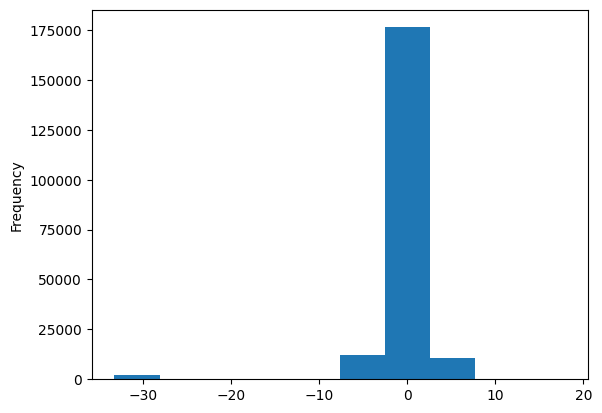

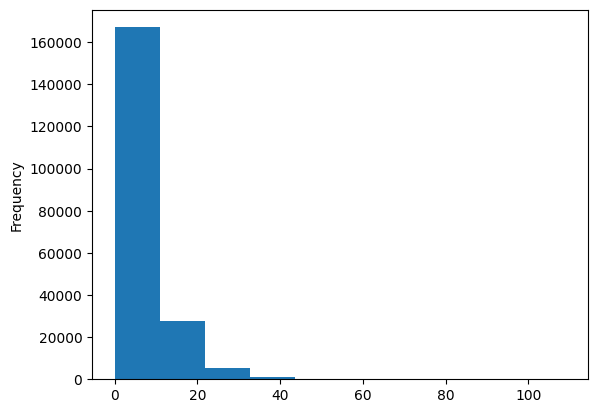

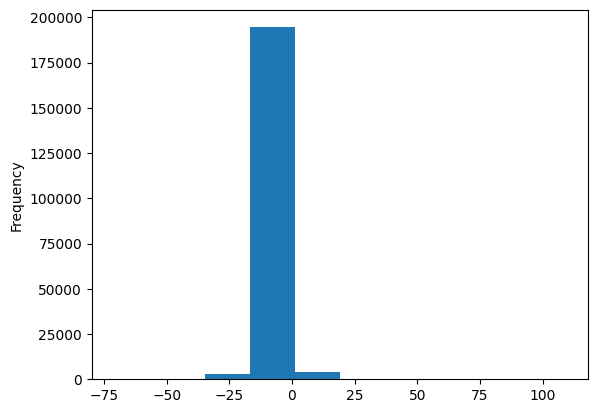

In [21]:
# 在熟悉基本比赛数据后，直觉上参赛者可考虑使用RFM分析，即采用recent、frequency、money进行
# 目标列相关性分析,简单起见，这里以new_transaction为例，由于都是最近记录因此就不统计recent
card_rfm = train[['card_id', 'target']].copy()

card_rfm['frequency'] = card_rfm['card_id'].map(new_transaction['card_id'].value_counts()).fillna(0).values
card_rfm['money'] = card_rfm['card_id'].map(new_transaction.groupby('card_id')['purchase_amount'].sum()).fillna(0).values

card_rfm = card_rfm.sort_values('target').reset_index(drop=True)
for col in ['target', 'frequency', 'money']:
    card_rfm[col].plot.hist()
    plt.show()
    
# 结论：可以看出，target高的用户集中在频次与消费都高的区域，这个发现也比较符合逻辑

In [22]:
new_transaction

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,0,C_ID_415bb3a509,107,0,1,2,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,0,C_ID_415bb3a509,140,0,1,2,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,0,C_ID_415bb3a509,330,0,1,2,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,0,C_ID_415bb3a509,-1,1,1,2,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1.0,-1,8
4,0,C_ID_ef55cf8d4b,-1,1,1,2,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1.0,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,0,C_ID_1320dee851,142,0,0,1,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,0,C_ID_f112aa3381,158,0,0,1,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,0,C_ID_bd97b86450,69,0,1,2,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,0,C_ID_c0513fd84f,130,0,0,1,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16
